In [1]:
import tensorflow as tf
from tensorflow.keras import applications, callbacks
from data_loader import create_datasets
from model_builders import MODEL_BUILDERS
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(24520152)

PREPROCESSOR = {
    "EfficientNetB5": applications.efficientnet.preprocess_input,
    "DenseNet121": applications.densenet.preprocess_input,
    "ResNet50V2": applications.resnet_v2.preprocess_input,
    "MobileNetV2": applications.mobilenet_v2.preprocess_input,
}

In [3]:
def train_and_save_model(model_name, train_dir, save_dir, num_classes, VAL_SPLIT=0.2, IMG_SIZE=(224, 224), BATCH_SIZE=32, DROPOUT_RATE=0.3, EPOCHS=50):
    # Prepare preprocess function and datasets
    preprocess_fn = PREPROCESSOR[model_name] 
    train_ds, val_ds = create_datasets(train_dir=train_dir, preprocess_fn=preprocess_fn, VAL_SPLIT=VAL_SPLIT, IMG_SIZE=IMG_SIZE, BATCH_SIZE=BATCH_SIZE)

    # Build model
    builder = MODEL_BUILDERS[model_name]
    model = builder(INPUT_SHAPE=(*IMG_SIZE, 3), NUM_CLASSES=num_classes, DROPOUT_RATE=DROPOUT_RATE)
    print(model.summary())

    # Compile model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Set up callbacks
    checkpoint_path = os.path.join(save_dir, f"{model_name}_best.keras")

    callback_list = [
        callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_accuracy",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
        ),
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            verbose=1,
            restore_best_weights=True,
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
        )
    ]

    # Train model
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callback_list,
        validation_data=val_ds,
    )

    return history

In [4]:
BASE_DIR = os.path.dirname(os.getcwd())
TRAIN_DIR = os.path.join(BASE_DIR, "dataset", "train")
SAVE_DIR = os.path.join(BASE_DIR, "checkpoints")
HIS_DIR = os.path.join(BASE_DIR, "history")

In [5]:
BASE_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification'

In [6]:
TRAIN_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\dataset\\train'

In [7]:
SAVE_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\checkpoints'

In [8]:
HIS_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\history'

In [9]:
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(HIS_DIR, exist_ok=True)

In [10]:
class_names = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [11]:
NUM_CLASSES = len(class_names)

In [12]:
MODELS = [
    "EfficientNetB5",
    "DenseNet121",
    "ResNet50V2",
    "MobileNetV2",
]

In [13]:
for model_name in MODELS:
    print(f"\nTraining model: {model_name}")
    history = train_and_save_model(
        model_name=model_name,
        train_dir=TRAIN_DIR,
        save_dir=SAVE_DIR,
        num_classes=NUM_CLASSES,
        EPOCHS=50,
    )
    pd.DataFrame(history.history).to_csv(os.path.join(HIS_DIR, f"{model_name}_history.csv"), index=False)


Training model: EfficientNetB5
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


Model: "EfficientNetB5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,525,821 (108.82 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 28,513,527 (108.77 MB)

None
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7804 - loss: 0.6559
Epoch 1: val_accuracy improved from None to 0.91839, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\EfficientNetB5_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.8488 - loss: 0.4406 - val_accuracy: 0.9184 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8862 - loss: 0.3042
Epoch 2: val_accuracy improved from 0.91839 to 0.92195, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\EfficientNetB5_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.8923 - loss: 0.2920 - val_accuracy: 0.9220 - val_loss: 0.2235 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8922 - loss: 0.2860
Epoch 3: val_accuracy did not improve from 0.92195
351/351 ━━━━━━

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.6616 - loss: 0.8850
Epoch 1: val_accuracy improved from None to 0.89950, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\DenseNet121_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.7815 - loss: 0.5933 - val_accuracy: 0.8995 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.8627 - loss: 0.3785
Epoch 2: val_accuracy improved from 0.89950 to 0.91661, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\DenseNet121_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.8660 - loss: 0.3625 - val_accuracy: 0.9166 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8777 - loss: 0.3394
Epoch 3: val_accuracy improved from 0.91661 to 0.91875, saving mo

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,577,094 (89.94 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

None
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.7325 - loss: 0.7141
Epoch 1: val_accuracy improved from None to 0.90485, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\ResNet50V2_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8282 - loss: 0.4693 - val_accuracy: 0.9048 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.8782 - loss: 0.3297
Epoch 2: val_accuracy improved from 0.90485 to 0.91019, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\ResNet50V2_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.8844 - loss: 0.3140 - val_accuracy: 0.9102 - val_loss: 0.2477 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8849 - loss: 0.3101
Epoch 3: val_accuracy improved from 0.91019 to 0.91233, saving m

c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\src\model_builders.py:107: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = applications.MobileNetV2(


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6857 - loss: 0.8023
Epoch 1: val_accuracy improved from None to 0.89522, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\MobileNetV2_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 140s 375ms/step - accuracy: 0.7975 - loss: 0.5327 - val_accuracy: 0.8952 - val_loss: 0.2864 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8581 - loss: 0.3740
Epoch 2: val_accuracy improved from 0.89522 to 0.89950, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\MobileNetV2_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 124s 350ms/step - accuracy: 0.8658 - loss: 0.3635 - val_accuracy: 0.8995 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8730 - loss: 0.3376
Epoch 3: val_accuracy improved from 0.89950 to 0.90734, 

In [14]:
histories = {}
for model_name in MODELS:
    file_path = os.path.join(HIS_DIR, f"{model_name}_history.csv")
    if os.path.exists(file_path):
        histories[model_name] = pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f"History file not found for {model_name} at {file_path}")

histories

{'EfficientNetB5':     accuracy      loss  val_accuracy  val_loss  learning_rate
 0   0.848771  0.440595      0.918389  0.242843          0.001
 1   0.892323  0.291970      0.921953  0.223533          0.001
 2   0.900962  0.273178      0.920171  0.211076          0.001
 3   0.901496  0.264852      0.926942  0.205185          0.001
 4   0.906484  0.249322      0.930506  0.196985          0.001
 5   0.906038  0.246082      0.930862  0.198218          0.001
 6   0.907909  0.243498      0.926586  0.200141          0.001
 7   0.908799  0.236547      0.928368  0.195256          0.001
 8   0.913698  0.228372      0.930862  0.196782          0.001
 9   0.911115  0.229312      0.933713  0.192649          0.001
 10  0.913253  0.228022      0.933713  0.194949          0.001
 11  0.916192  0.225035      0.930150  0.189307          0.001
 12  0.915924  0.220834      0.929793  0.196350          0.001
 13  0.914054  0.222180      0.930862  0.197673          0.001
 14  0.915034  0.222746      0.930150

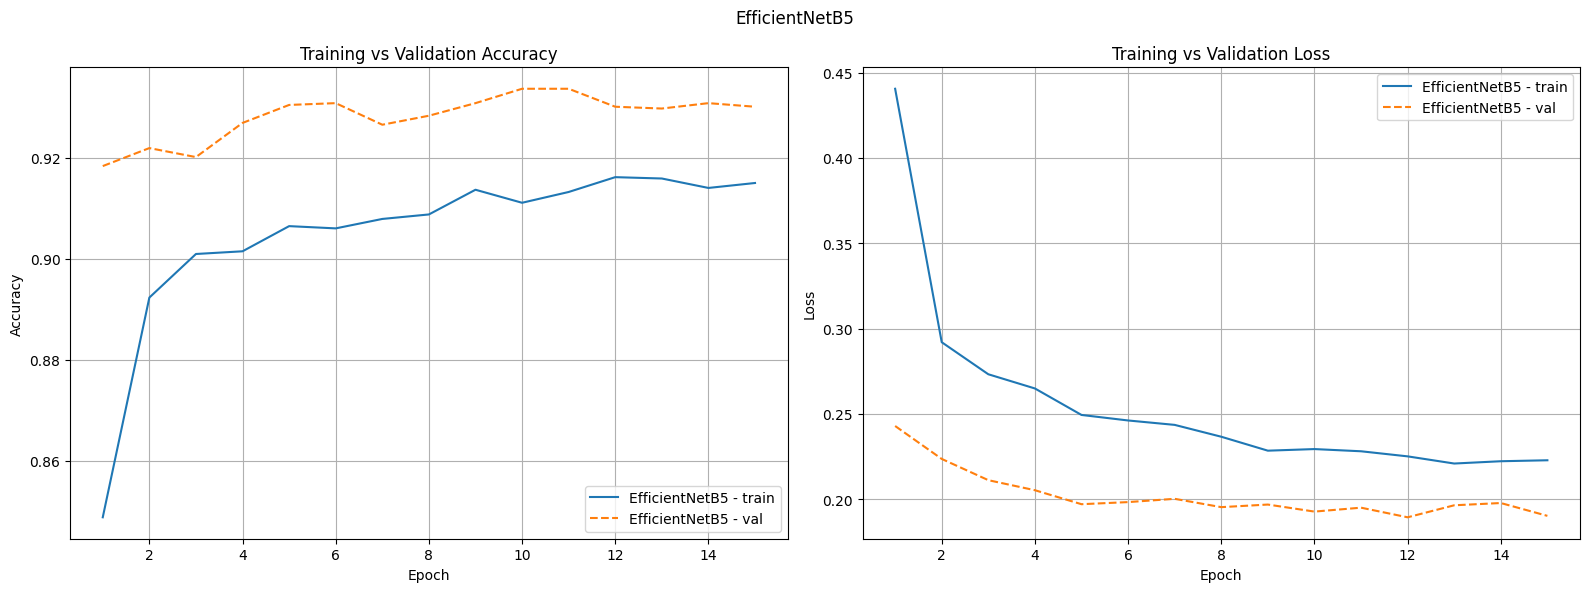

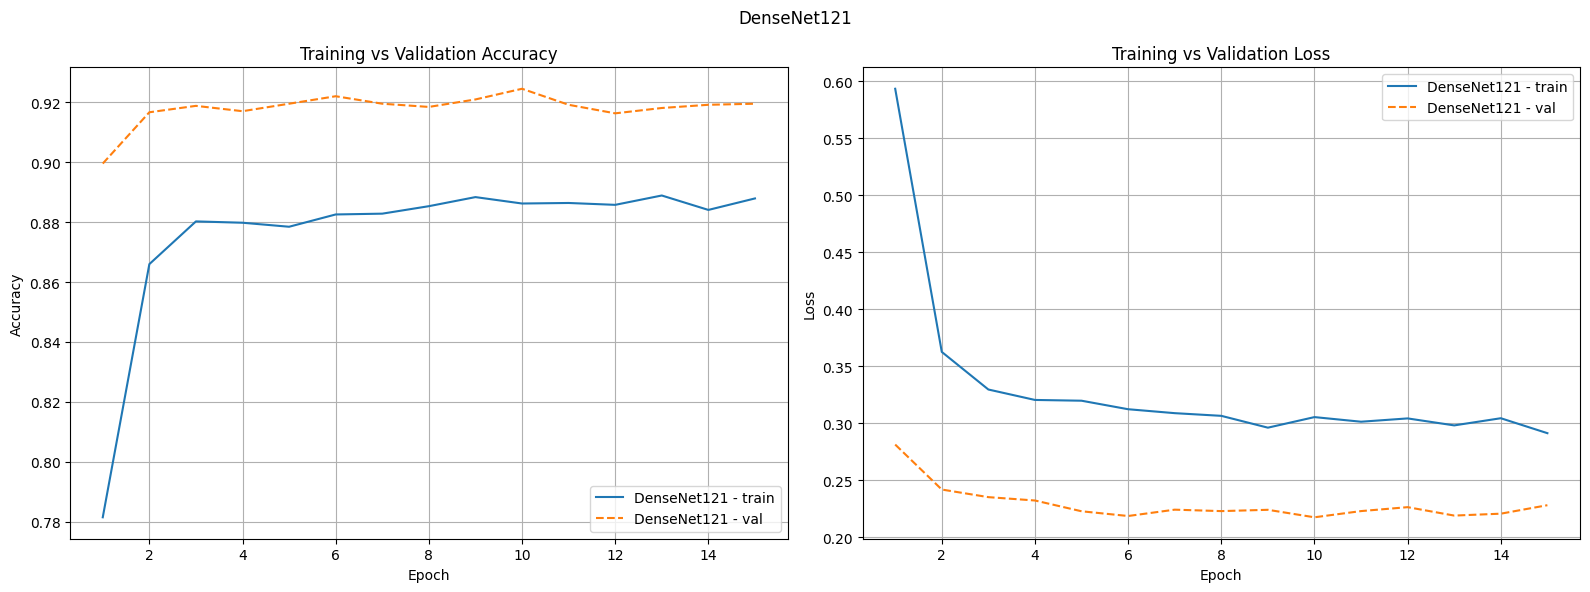

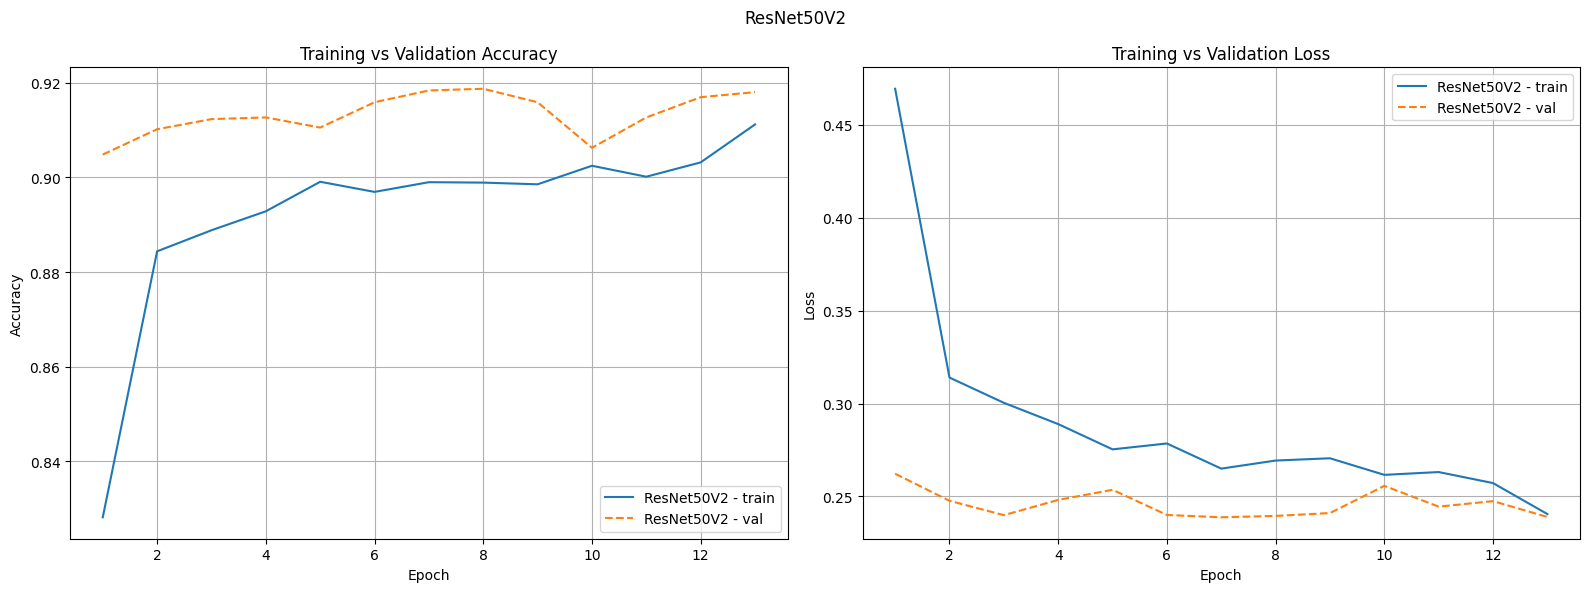

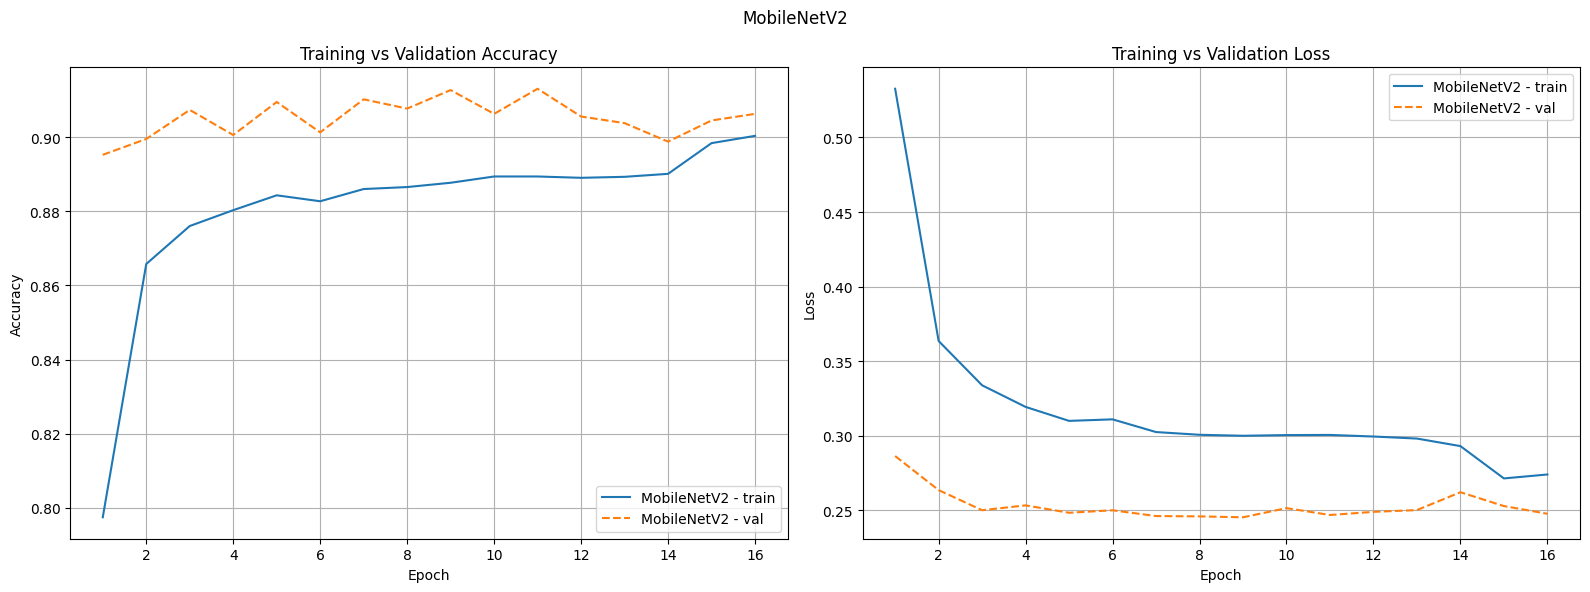

In [15]:
for name, hist in histories.items():
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"{name}")

    axs[0].plot(range(1, len(hist["accuracy"]) + 1), hist["accuracy"], label=f"{name} - train")
    axs[0].plot(range(1, len(hist["val_accuracy"]) + 1), hist["val_accuracy"], linestyle="--", label=f"{name} - val")
    axs[0].set_title("Training vs Validation Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(range(1, len(hist["loss"]) + 1), hist["loss"], label=f"{name} - train")
    axs[1].plot(range(1, len(hist["val_loss"]) + 1), hist["val_loss"], linestyle="--", label=f"{name} - val")
    axs[1].set_title("Training vs Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid()

    fig.tight_layout()

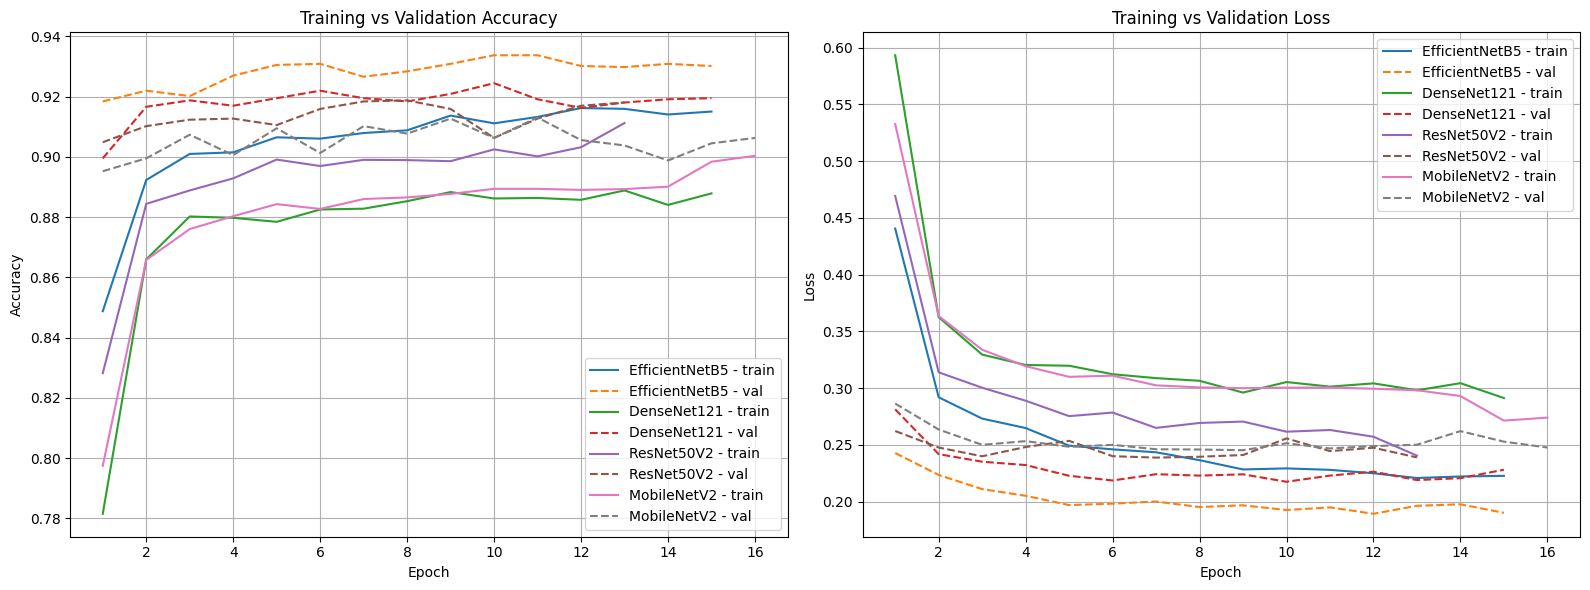

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for name, hist in histories.items():
    axs[0].plot(range(1, len(hist["accuracy"]) + 1), hist["accuracy"], label=f"{name} - train")
    axs[0].plot(range(1, len(hist["val_accuracy"]) + 1), hist["val_accuracy"], linestyle="--", label=f"{name} - val")
axs[0].set_title("Training vs Validation Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid()

for name, hist in histories.items():
    axs[1].plot(range(1, len(hist["loss"]) + 1), hist["loss"], label=f"{name} - train")
    axs[1].plot(range(1, len(hist["val_loss"]) + 1), hist["val_loss"], linestyle="--", label=f"{name} - val")
axs[1].set_title("Training vs Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid()

fig.tight_layout()

In [17]:
summary_data = []

for name, hist in histories.items():
    best_epoch = hist["val_accuracy"].idxmax() + 1
    best_val_acc = hist["val_accuracy"].max()
    best_val_loss = hist["val_loss"][best_epoch - 1]
    final_train_acc = hist["accuracy"].iloc[-1]
    final_val_acc = hist["val_accuracy"].iloc[-1]

    summary_data.append({
        "Model": name,
        "Best Epoch": best_epoch,
        "Best Val Accuracy": best_val_acc,
        "Best Val Loss": best_val_loss,
        "Final Train Accuracy": final_train_acc,
        "Final Val Accuracy": final_val_acc,
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Best Val Accuracy", ascending=False).reset_index(drop=True)
summary_df.style.background_gradient(cmap="Blues", subset=["Best Val Accuracy"])

,Model,Best Epoch,Best Val Accuracy,Best Val Loss,Final Train Accuracy,Final Val Accuracy
0,EfficientNetB5,10,0.933713,0.192649,0.915034,0.930150
1,DenseNet121,10,0.924448,0.217521,0.887870,0.919458
2,ResNet50V2,8,0.918746,0.239561,0.911204,0.918033
3,MobileNetV2,11,0.913043,0.246876,0.900338,0.906272
